# Proyek Klasifikasi Gambar: Jenis Beras (https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset)
####Abstrak:
- **Nama:** Tok Se Ka
- **Email:** sekacoding@gmail.com
- **ID Dicoding:** MC185D5Y2370

ini berisi foto dari 5 jenis beras yang memiliki jumlah foto yang seimbang dan memiliki total 75000 file gambar yang tersebar masing masing 15000 foto per kelas.

### Mengimport library yang diperlukan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import os
import shutil

from sklearn.utils.class_weight import compute_class_weight

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"toksekamc185d5y2370","key":"90fa6e7872eb30a7fc8b3adc406b2b47"}'}

### Mengimport folder kaggle dan langsung unzip di colab.

In [4]:
# 1. Buat folder .kaggle
!mkdir -p ~/.kaggle
# 2. Pindahkan file kaggle.json ke folder .kaggle
!cp kaggle.json ~/.kaggle/
# 3. Ubah permission-nya agar hanya bisa diakses sendiri
!chmod 600 ~/.kaggle/kaggle.json
# 4. Install dan gunakan kaggle CLI
!pip install -q kaggle
# 5. Download dataset dari Kaggle
!kaggle datasets download -d muratkokludataset/rice-image-dataset
# 6. Unzip dataset-nya
!unzip rice-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karacadag/K

### Menghapus txt dan ipynb_checkpoints yang tidak berhubungan dengan dataset.

In [5]:
!rm -r Rice_Image_Dataset/.ipynb_checkpoints #checkpointnya muncul didalam dataset
!rm -r Rice_Image_Dataset/Rice_Citation_Request.txt #checkpointnya muncul didalam dataset

rm: cannot remove 'Rice_Image_Dataset/.ipynb_checkpoints': No such file or directory


### Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data dan menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih

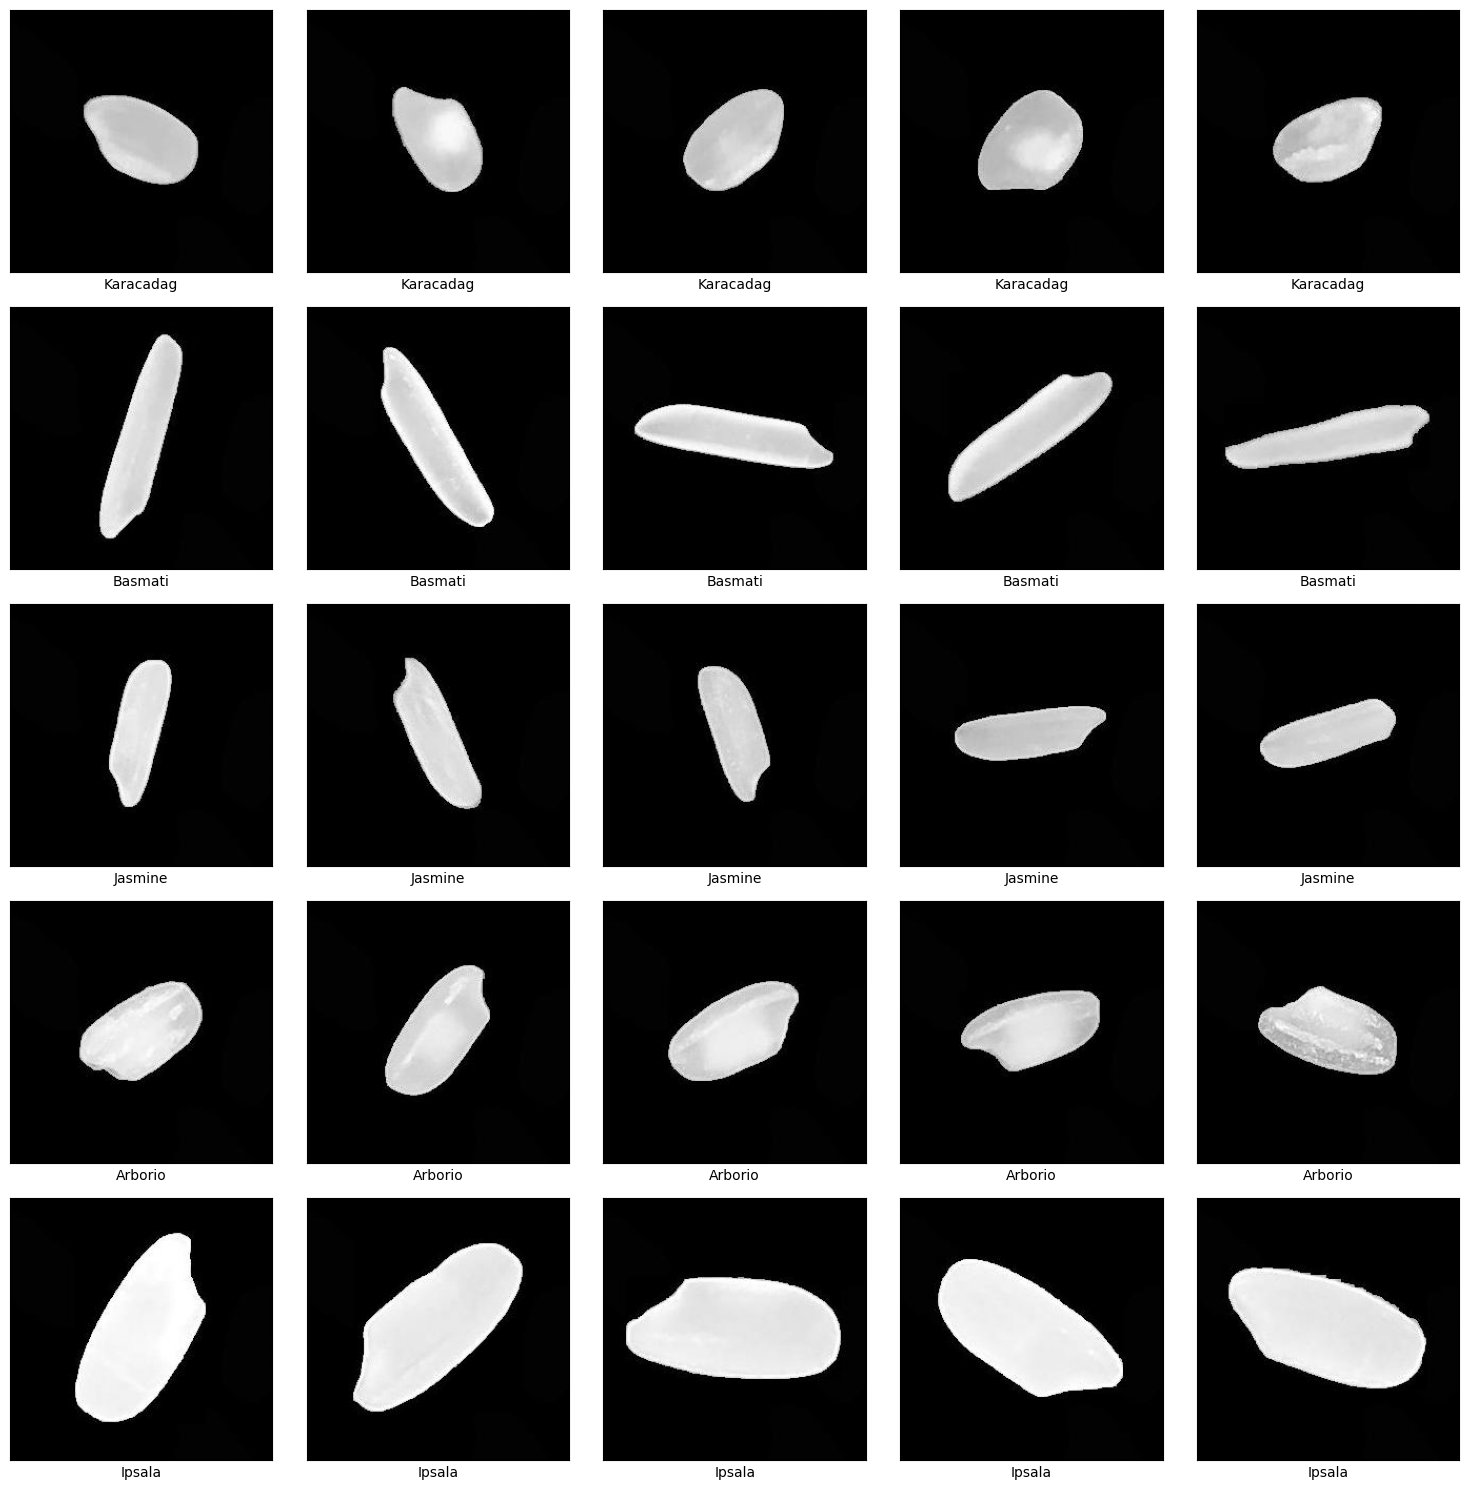

In [6]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
rice_image = {}

# Tentukan path sumber train
path = "Rice_Image_Dataset/"

for i in os.listdir(path):
    rice_image[i] = os.listdir(os.path.join(path, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(rice_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(rice_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

### Melihat dan memberikan label untuk setiap gambar sesuai dengan folder yang ditempati, dan melakukan plot distribusi gambar untuk melihat pesebaran gambar yang telah di unduh (semuanya sama rata).

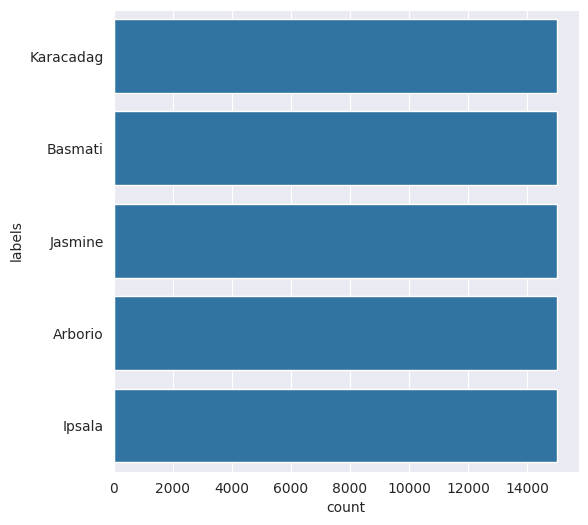

In [7]:
# Definisikan path sumber
rice_path = "Rice_Image_Dataset"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(rice_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Untuk memastikan ulang, melihat kembali dan menampilkannya dalam bentuk dataframe

In [8]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'Rice_Image_Dataset'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Arborio,15000
Basmati,15000
Ipsala,15000
Jasmine,15000
Karacadag,15000


### Memisahkan datasetmenjadi data train dan data test

In [9]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [10]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [11]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "chest_xray/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels   
test   Arborio       2983
       Basmati       2963
       Ipsala        2988
       Jasmine       3040
       Karacadag     3026
train  Arborio      12017
       Basmati      12037
       Ipsala       12012
       Jasmine      11960
       Karacadag    11974
dtype: int64 


                                                    path     labels    set
30452        Rice_Image_Dataset/Ipsala/Ipsala (5430).jpg     Ipsala  train
4116       Rice_Image_Dataset/Basmati/basmati (5132).jpg    Basmati  train
56090  Rice_Image_Dataset/Karacadag/Karacadag (12524)...  Karacadag  train
28128      Rice_Image_Dataset/Jasmine/Jasmine (3090).jpg    Jasmine  train
64470      Rice_Image_Dataset/Arborio/Arborio (4561).jpg    Arborio   test


In [12]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [13]:
# Definisikan direktori train dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

# Ambil nama-nama kelas (folder di dalam train)
rice_classes = os.listdir(TRAIN_DIR)

# Hitung jumlah file per kelas di train dan test
print("=== TRAIN DATA ===")
for rice_class in rice_classes:
    class_dir = os.path.join(TRAIN_DIR, rice_class)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        print(f"Jumlah gambar kelas {rice_class} (train): {num_images}")

print("\n=== TEST DATA ===")
for rice_class in rice_classes:
    class_dir = os.path.join(TEST_DIR, rice_class)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        print(f"Jumlah gambar kelas {rice_class} (test): {num_images}")


=== TRAIN DATA ===
Jumlah gambar kelas Karacadag (train): 11974
Jumlah gambar kelas Basmati (train): 12037
Jumlah gambar kelas Jasmine (train): 11960
Jumlah gambar kelas Arborio (train): 12017
Jumlah gambar kelas Ipsala (train): 12012

=== TEST DATA ===
Jumlah gambar kelas Karacadag (test): 3026
Jumlah gambar kelas Basmati (test): 2963
Jumlah gambar kelas Jasmine (test): 3040
Jumlah gambar kelas Arborio (test): 2983
Jumlah gambar kelas Ipsala (test): 2988


### Dataset Dibagi Menjadi Train Set, Test Set dan Validation Set.

In [14]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 48002 images belonging to 5 classes.
Found 11998 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [15]:
print("Train steps per epoch:", train_generator.samples)
print("Validation steps per epoch:", validation_generator.samples)
print("Test samples:", test_generator.samples)

Train steps per epoch: 48002
Validation steps per epoch: 11998
Test samples: 15000


### Melatih Model Menggunakan Model Sequential, Conv2D, Pooling Layer
#####Model CNN dibangun menggunakan arsitektur Sequential dari Keras, yang memungkinkan penambahan layer secara berurutan dan intuitif. Model ini terdiri dari tiga blok Conv2D yang masing-masing diikuti oleh BatchNormalization dan MaxPooling, sehingga mampu mengekstraksi fitur spasial dari gambar input berukuran 150x150 piksel dalam format grayscale.

#####Setelah ekstraksi fitur, model dilanjutkan dengan beberapa fully connected layer dan Dropout untuk mencegah overfitting. Lapisan output menggunakan softmax untuk mengklasifikasikan gambar ke dalam lima kelas.

#####Model dikompilasi dengan optimizer RMSprop, fungsi loss categorical_crossentropy, dan metrik accuracy.

In [16]:
####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional Block
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional Block
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional Block
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Fully Connected Layers
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.3))

# Output Layer (5 kelas → softmax)
model_1.add(Dense(5, activation='softmax'))

# Compile
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Print arsitektur
model_1.summary()

# Bersihkan session lama (optional)
tf.keras.backend.clear_session()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,141 (5.35 MB)

 Trainable params: 1,402,949 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

### Menambahkan callback

In [25]:
# Callbacks
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

###MengaMbil label dan melakukan training model / fitting

In [26]:
# Ambil label class dari generator
labels = train_generator.classes

# Hitung class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Konversi ke dict
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)


%time

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights,
                        callbacks=[checkpoint, early_stopping])

Class weights: {0: np.float64(0.9985853962970668), 1: np.float64(0.996926272066459), 2: np.float64(0.9990010405827263), 3: np.float64(1.003386287625418), 4: np.float64(1.0021294363256785)}
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs
Epoch 1/30
1500/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9300 - loss: 0.2214
Epoch 1: val_loss improved from inf to 0.12680, saving model to best_model.h5


1501/1501 ━━━━━━━━━━━━━━━━━━━━ 55s 36ms/step - accuracy: 0.9300 - loss: 0.2214 - val_accuracy: 0.9657 - val_loss: 0.1268
Epoch 2/30
1500/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9332 - loss: 0.2253
Epoch 2: val_loss did not improve from 0.12680
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.9332 - loss: 0.2253 - val_accuracy: 0.9259 - val_loss: 0.1980
Epoch 3/30
1500/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9353 - loss: 0.2056
Epoch 3: val_loss did not improve from 0.12680
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 55s 37ms/step - accuracy: 0.9353 - loss: 0.2056 - val_accuracy: 0.9573 - val_loss: 0.1686
Epoch 4/30
1500/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9360 - loss: 0.2103
Epoch 4: val_loss did not improve from 0.12680
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 56s 38ms/step - accuracy: 0.9360 - loss: 0.2103 - val_accuracy: 0.8535 - val_loss: 1.3158
Epoch 5/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9374 - loss: 0.2090
Epoch 5: val_loss i

1501/1501 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.9374 - loss: 0.2090 - val_accuracy: 0.9727 - val_loss: 0.1201
Epoch 6/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9411 - loss: 0.1893
Epoch 6: val_loss did not improve from 0.12008
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 56s 37ms/step - accuracy: 0.9411 - loss: 0.1893 - val_accuracy: 0.9539 - val_loss: 0.3474
Epoch 7/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9416 - loss: 0.1800
Epoch 7: val_loss did not improve from 0.12008
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.9416 - loss: 0.1800 - val_accuracy: 0.9419 - val_loss: 0.2208
Epoch 8/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9411 - loss: 0.1836
Epoch 8: val_loss improved from 0.12008 to 0.06662, saving model to best_model.h5


1501/1501 ━━━━━━━━━━━━━━━━━━━━ 55s 37ms/step - accuracy: 0.9411 - loss: 0.1836 - val_accuracy: 0.9867 - val_loss: 0.0666
Epoch 9/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9430 - loss: 0.1775
Epoch 9: val_loss did not improve from 0.06662
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.9430 - loss: 0.1775 - val_accuracy: 0.9753 - val_loss: 0.1106
Epoch 10/30
1500/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9419 - loss: 0.1781
Epoch 10: val_loss did not improve from 0.06662
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 55s 36ms/step - accuracy: 0.9419 - loss: 0.1781 - val_accuracy: 0.8972 - val_loss: 0.3511
Epoch 11/30
1500/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9402 - loss: 0.1919
Epoch 11: val_loss did not improve from 0.06662
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.9402 - loss: 0.1919 - val_accuracy: 0.7311 - val_loss: 0.7762
Epoch 12/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9412 - loss: 0.1792
Epoch 12: val_

1501/1501 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.9517 - loss: 0.1591 - val_accuracy: 0.9822 - val_loss: 0.0623
Epoch 14/30
1500/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9576 - loss: 0.1530
Epoch 14: val_loss did not improve from 0.06228
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.9576 - loss: 0.1530 - val_accuracy: 0.9822 - val_loss: 0.0675
Epoch 15/30
1500/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9593 - loss: 0.1450
Epoch 15: val_loss did not improve from 0.06228
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.9593 - loss: 0.1450 - val_accuracy: 0.9789 - val_loss: 0.0977
Epoch 16/30
1500/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9655 - loss: 0.1418
Epoch 16: val_loss did not improve from 0.06228
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 55s 36ms/step - accuracy: 0.9655 - loss: 0.1418 - val_accuracy: 0.9838 - val_loss: 0.0723
Epoch 17/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9658 - loss: 0.1383
Epoch 17: va

###Melihat nilai akurasi dan loss dari hasil training
#####Agak tidak stabil, tetapi masih bisa di toleransi seharusnya.

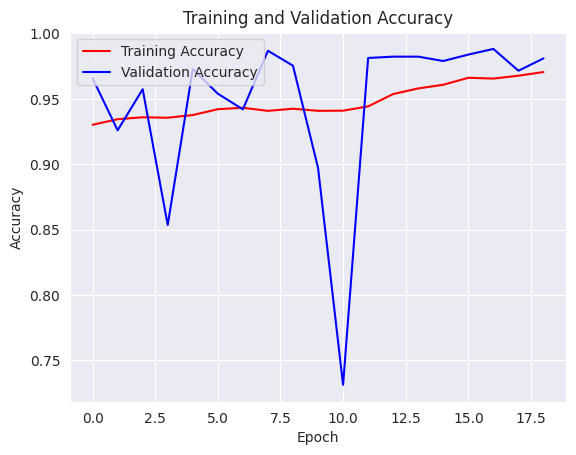

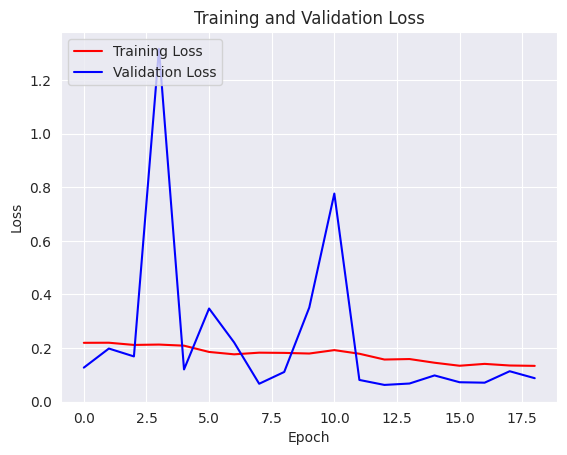

In [27]:
# Ambil nilai akurasi dan loss dari hasil training
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

# Epochs-nya diambil dari panjang data history
epochs = range(len(acc))

# Plot Accuracy
plt.figure()
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot Loss
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Melakukan pengecekan ulang menggunakan Confusion Matrix beserta Classification Report.
#####Setelah proses pelatihan selesai, model dievaluasi kembali menggunakan confusion matrix dan classification report untuk mengetahui performa klasifikasi secara lebih detail per kelas.

#####Gambar di bawah menunjukkan bahwa mayoritas prediksi model tepat pada kelasnya masing-masing, dengan sangat sedikit kesalahan antar kelas.

#####Model memiliki performa sangat tinggi secara keseluruhan, dengan:
- Accuracy: 99.11%
- F1-Score per kelas: semuanya di atas 0.98
- Macro avg & weighted avg: juga 0.9911

#####Hal ini menunjukkan bahwa model tidak hanya unggul pada kelas mayoritas, tapi juga mampu mempertahankan performa tinggi di semua kelas secara merata.

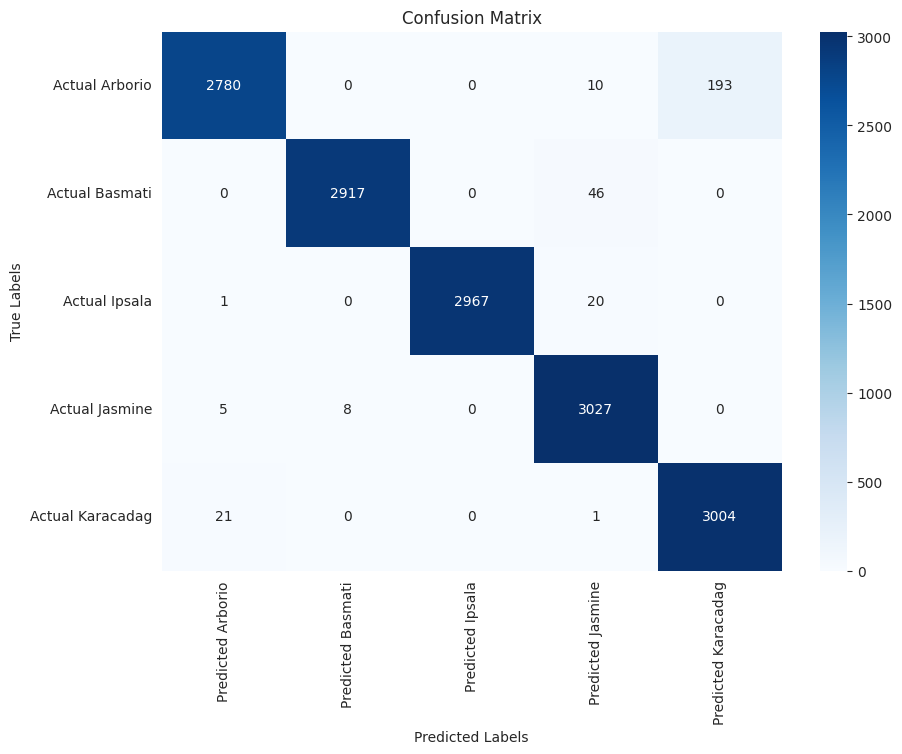


Classification Report:

              precision    recall  f1-score   support

     Arborio     0.9904    0.9319    0.9603      2983
     Basmati     0.9973    0.9845    0.9908      2963
      Ipsala     1.0000    0.9930    0.9965      2988
     Jasmine     0.9752    0.9957    0.9854      3040
   Karacadag     0.9396    0.9927    0.9655      3026

    accuracy                         0.9797     15000
   macro avg     0.9805    0.9796    0.9797     15000
weighted avg     0.9803    0.9797    0.9796     15000



In [28]:
# Reset generator untuk memastikan prediksi mulai dari awal
test_generator.reset()

# Prediksi
preds_1 = model_1.predict(test_generator, verbose=0)

# Ambil index dengan probabilitas tertinggi (prediksi kelas)
y_pred = np.argmax(preds_1, axis=1)

# Ambil label asli
y_true = test_generator.classes

# Daftar nama kelas (kalau ada, ambil dari generator)
class_names = list(test_generator.class_indices.keys())  # atau ['class1', 'class2', ..., 'class5']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=[f'Actual {name}' for name in class_names],
                        columns=[f'Predicted {name}' for name in class_names])

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

### Menyimpan model dalam bentuk savedmodel

In [29]:
save_path = 'mymodel/'
tf.saved_model.save(model_1, save_path)

### Menyimpan model dalam bentuk tensorflow.js

In [40]:
!tensorflowjs_converter \
  --input_format=tf_saved_model \
  mymodel \
  web_model

2025-04-25 18:39:40.444806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745606380.464608   13183 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745606380.470661   13183 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-25 18:39:44.534367: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745606384.534541   13183 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

### Dalam bentuk tensorflow lite

In [38]:
converter = tf.lite.TFLiteConverter.from_saved_model('mymodel')
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model_1.tflite')
tflite_model_file.write_bytes(tflite_model)

16260

### Memakai model yang telah tersimpan sebelumnya.
##### Setelah di load, lalu diambil dataset dari test generator sebagai bahan test karena belum pernah dihapal oleh model, diambil 1 pcs untuk bahan test (data ke 12345). Setelah itu ditampilkan gambar, label, serta hasilnya untuk melihat seberapa baik model ini menampilkan dan menjawab gambarnya.

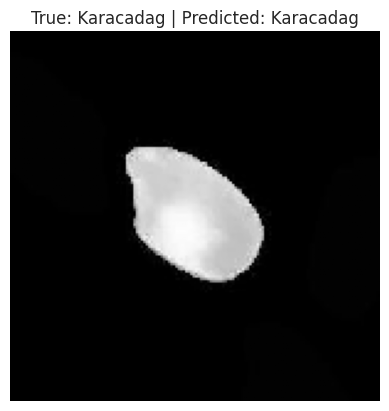

Probabilitas prediksi:
Arborio: 0.0002
Basmati: 0.0000
Ipsala: 0.0000
Jasmine: 0.0000
Karacadag: 0.9998


In [32]:
# Load model dari SavedModel dengan Keras 3
inference_layer = keras.layers.TFSMLayer("mymodel", call_endpoint="serving_default")

# Ambil 1 gambar dari test_generator
test_generator.reset()
x, y = test_generator[12345]  # batch 12345
image = x[0]              # ambil satu gambar
true_label = y[0]         # ambil label aslinya (one-hot)

# Inference
result = inference_layer(np.expand_dims(image, axis=0))
pred_probs = result["output_0"]
pred_class = np.argmax(pred_probs)
true_class = np.argmax(true_label)

# Mapping label ke nama kelas
class_names = list(test_generator.class_indices.keys())

# Tampilkan gambar & hasil prediksi
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"True: {class_names[true_class]} | Predicted: {class_names[pred_class]}")
plt.axis("off")
plt.show()

# Tampilkan probabilitas prediksi
print("Probabilitas prediksi:")
for i, prob in enumerate(pred_probs[0]):
    print(f"{class_names[i]}: {prob:.4f}")
